In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [5]:
df.isna().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
df.drop('CustomerID', axis=1, inplace=True)

In [8]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


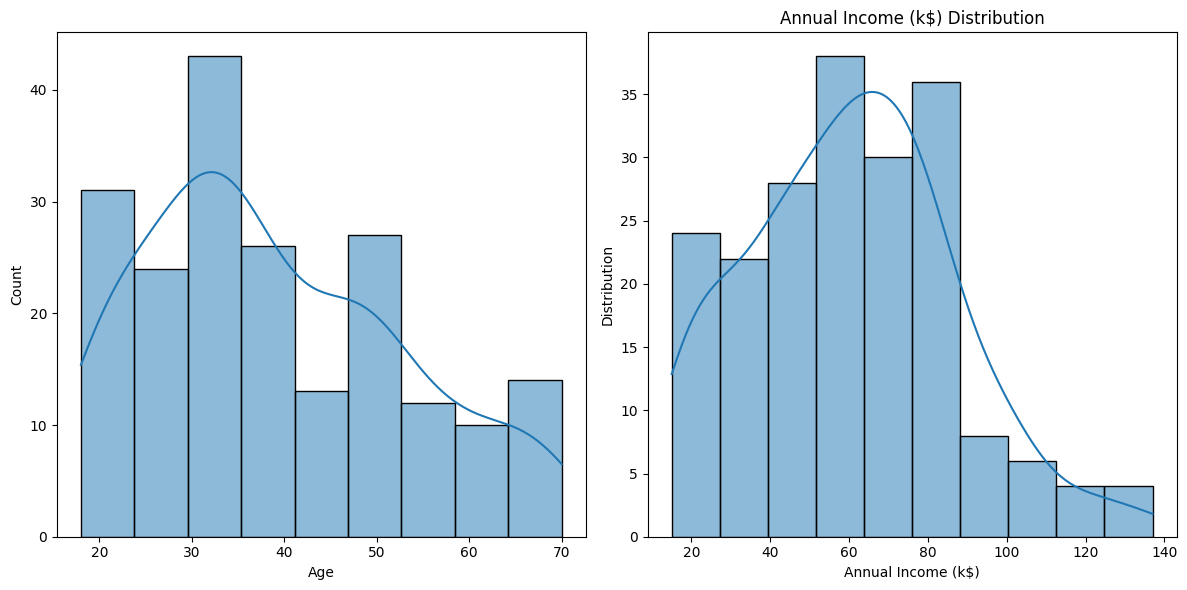

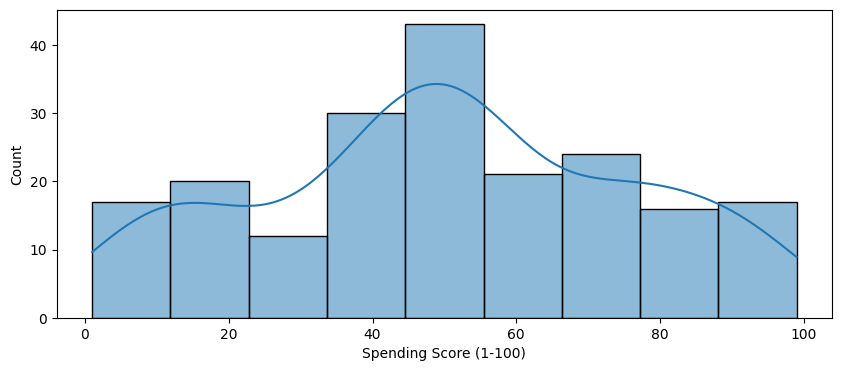

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

for i, feature in enumerate(['Age', 'Annual Income (k$)']):
    sns.histplot(df[feature], ax=axes[i], kde=True)
    plt.xlabel(feature)
    plt.ylabel("Distribution")
    plt.title(f"{feature} Distribution")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df['Spending Score (1-100)'], kde=True)
plt.show()

In [10]:
hot_enc = OneHotEncoder(sparse_output=False)
gender_encoded = hot_enc.fit_transform(df[['Gender']])
gender_df = pd.DataFrame(gender_encoded, columns=hot_enc.get_feature_names_out(['Gender']))
combined_df = pd.concat([df.drop('Gender', axis=1), gender_df], axis=1)
combined_df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0.0,1.0
1,21,15,81,0.0,1.0
2,20,16,6,1.0,0.0
3,23,16,77,1.0,0.0
4,31,17,40,1.0,0.0


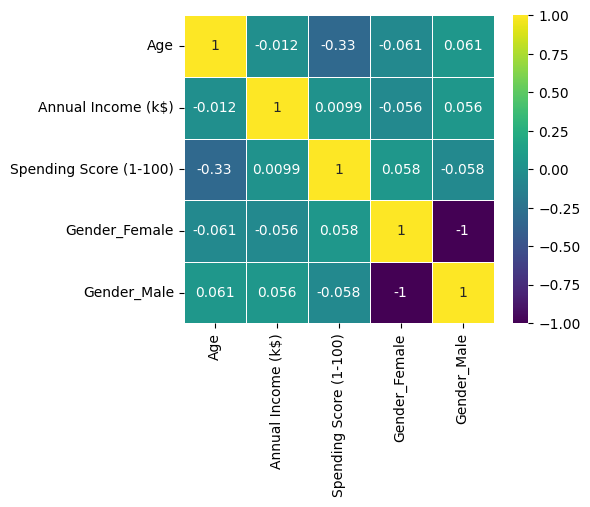

In [11]:
corr_matrix = combined_df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, cmap='viridis', linewidth=0.5, vmin=-1, vmax=1, annot=True)
plt.show()

In [12]:
for col in combined_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]:
    print(combined_df[col].skew())

0.48556885096681657
0.3218425498619055
-0.047220201374263374


In [13]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(combined_df.drop(['Gender_Female', 'Gender_Male'], axis=1)), columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
final_df = pd.concat([scaled_df, combined_df.drop(scaled_df.columns, axis=1)], axis=1)
final_df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0


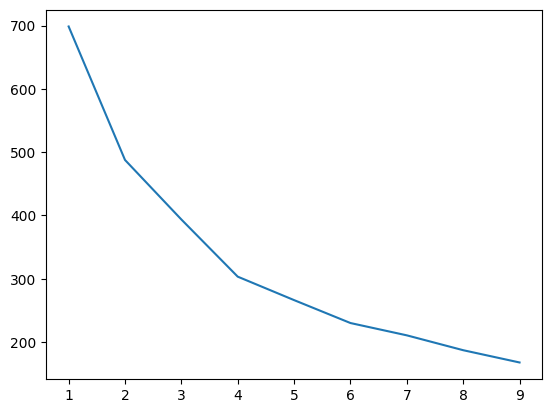

In [14]:
inertia_list = []
for i in range(1, 10):
    kmeans = KMeans(n_init=10, n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit_predict(final_df)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia_list)
plt.show()

In [15]:
features_for_clustering = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female', 'Gender_Male']

In [16]:
kmeans = KMeans(n_init=10, n_clusters=4, random_state=0)
kmeans.fit(final_df)
final_df['KMeans Cluster'] = kmeans.predict(final_df)
kmeans_score = silhouette_score(final_df[features_for_clustering], final_df['KMeans Cluster'])
print(kmeans_score)
final_df.head()

0.3194701864060389


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,KMeans Cluster
0,-1.424569,-1.738999,-0.434801,0.0,1.0,2
1,-1.281035,-1.738999,1.195704,0.0,1.0,2
2,-1.352802,-1.700830,-1.715913,1.0,0.0,2
3,-1.137502,-1.700830,1.040418,1.0,0.0,2
4,-0.563369,-1.662660,-0.395980,1.0,0.0,2


In [17]:
scanner = DBSCAN(eps=1, min_samples=3)
scanner.fit(final_df[features_for_clustering])
labels = scanner.labels_
final_df['Scanner Cluster'] = labels
print(np.unique(labels))
scanner_score = silhouette_score(final_df[features_for_clustering], final_df['Scanner Cluster'])
print(scanner_score)
final_df.head()

[-1  0  1  2]
0.13088116557057142


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,KMeans Cluster,Scanner Cluster
0,-1.424569,-1.738999,-0.434801,0.0,1.0,2,-1
1,-1.281035,-1.738999,1.195704,0.0,1.0,2,0
2,-1.352802,-1.700830,-1.715913,1.0,0.0,2,-1
3,-1.137502,-1.700830,1.040418,1.0,0.0,2,1
4,-0.563369,-1.662660,-0.395980,1.0,0.0,2,1


In [18]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(final_df[features_for_clustering])
final_df['Agglo Cluster'] = agglo_labels
agglo_score = silhouette_score(final_df[features_for_clustering], final_df['Agglo Cluster'])
print(agglo_score)
print(final_df.head())

0.29983700423456283
        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Female  \
0 -1.424569           -1.738999               -0.434801            0.0   
1 -1.281035           -1.738999                1.195704            0.0   
2 -1.352802           -1.700830               -1.715913            1.0   
3 -1.137502           -1.700830                1.040418            1.0   
4 -0.563369           -1.662660               -0.395980            1.0   

   Gender_Male  KMeans Cluster  Scanner Cluster  Agglo Cluster  
0          1.0               2               -1              0  
1          1.0               2                0              1  
2          0.0               2               -1              0  
3          0.0               2                1              1  
4          0.0               2                1              0  


In [19]:
mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(final_df[features_for_clustering])
final_df['Mean Shift Cluster'] = mean_shift_labels
if len(set(mean_shift.labels_)) > 1:
    mean_shift_score = silhouette_score(final_df[features_for_clustering], final_df['Mean Shift Cluster'])
    print(mean_shift_score)
    print(final_df.head)
else:
    print("Only 1 Label (Clustering Failed)")

Only 1 Label (Clustering Failed)


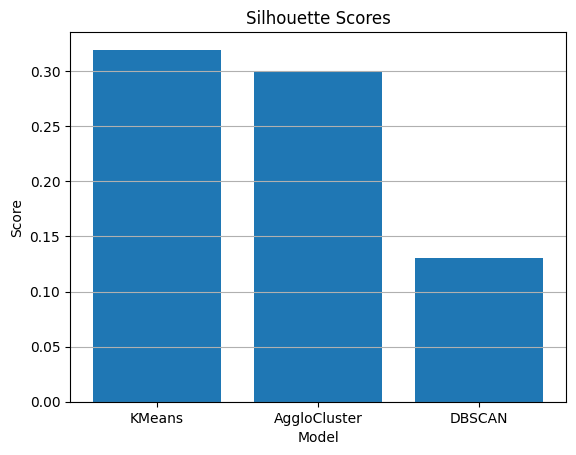

In [20]:
scores = pd.Series([kmeans_score, scanner_score, agglo_score], index=['KMeans', 'DBSCAN', 'AggloCluster'])
scores = scores.sort_values(ascending=False)
plt.bar(scores.index, scores.values)
plt.grid()
plt.title("Silhouette Scores")
plt.xlabel("Model")
plt.ylabel("Score")
plt.grid(axis='x')
plt.show()

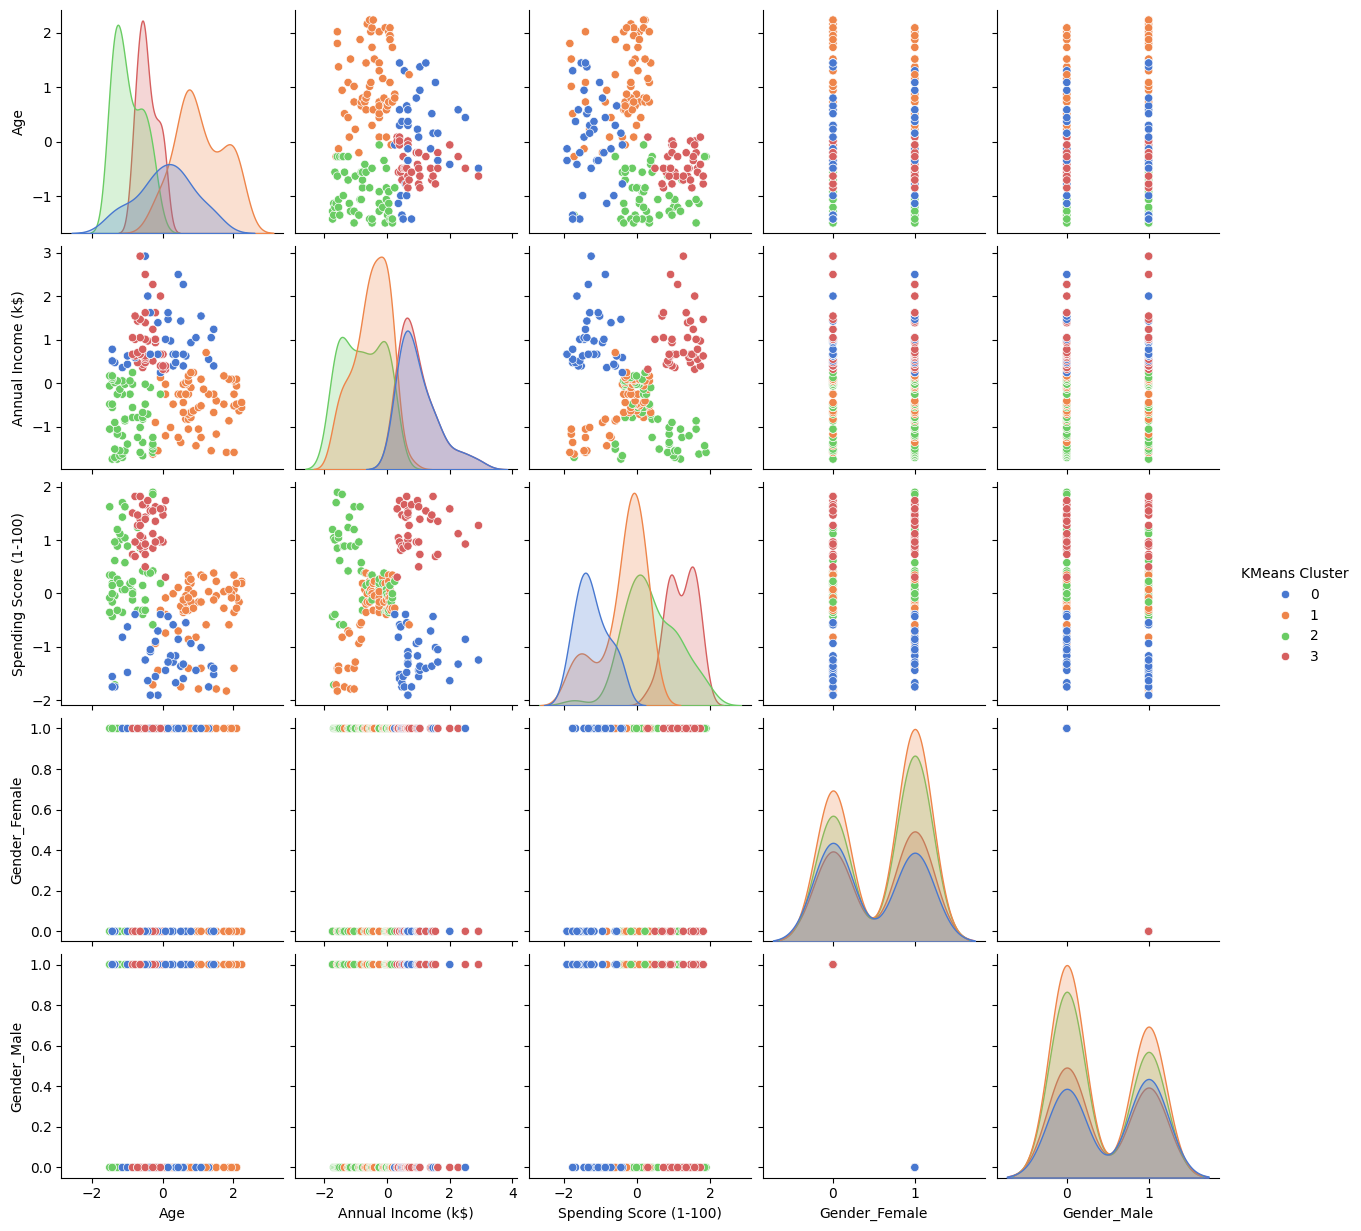

In [21]:
sns.pairplot(final_df[features_for_clustering + ['KMeans Cluster']], hue='KMeans Cluster', palette='muted')
plt.show()